[This notebook](https://github.com/dattalab/keypoint-moseq/blob/main/docs/source/modeling.ipynb) shows how to setup a new project, train a keypoint-MoSeq model and visualize the resulting syllables. 

```{note}
The calibration step below requires jupyterlab launched from the `keypoint_moseq` environment. It will not work in jupyter notebook.
```


# Project setup
Create a new project directory with a keypoint-MoSeq `config.yml` file.

In [19]:
import keypoint_moseq as kpms

project_dir = 'Chronic_LDOPA'
config = lambda: kpms.load_config(project_dir)

In [23]:
dlc_config = 'dlc_project/config.yaml'
kpms.setup_project(project_dir, deeplabcut_config=dlc_config)

The directory `MITOPARK_DLC` already exists. Use `overwrite=True` or
pick a different name


In [ ]:
sleap_file = 'XXX' # any .slp or .h5 file with predictions for a single video
kpms.setup_project(project_dir, sleap_file=sleap_file)

In [3]:
bodyparts=[
    'nose', 'head', 'l_ear', 'r_ear', 'cervical_spine',
    'thoracic spine', 'lumbar_spine', 'tail base']

skeleton=[
    ['tail base', 'lumbar_spine'],
    ['lumbar_spine', 'thoracic spine'],
    ['thoracic spine', 'cervical_spine'],
    ['cervical_spine', 'head'],
    ['nose', 'head'],
    ['l_ear', 'head'],
    ['r_ear', 'head']]

video_dir='6OHDA_DLC'

kpms.setup_project(
    project_dir,
    video_dir=video_dir,
    bodyparts=bodyparts,
    skeleton=skeleton, overwrite=True)

## Edit the config file

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

- `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)
- `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)
- `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)
- `video_dir` (directory with videos of each experiment)

Edit the config as follows for the [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link):

In [6]:
kpms.update_config(
    project_dir,
    video_dir='MITOPARK_DLC',
    anterior_bodyparts=['nose'],
    posterior_bodyparts=['tail base'],
    use_bodyparts=[
    'nose', 'head', 'l_ear', 'r_ear', 'cervical_spine',
    'thoracic spine', 'lumbar_spine', 'tail base'])

## Load data

The code below shows how to load keypoint detections from DeepLabCut. To load other formats, replace `'deeplabcut'` in the example with one of `'sleap', 'anipose', 'sleap-anipose', 'nwb'`. For other formats, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#loading-keypoint-tracking-data).

In [3]:
# load data (e.g. from DeepLabCut)
#keypoint_data_path = 'MITOPARK_DLC/tracking/' # can be a file, a directory, or a list of files
keypoint_data_path = 'Chronic_LDOPA/tracking/' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'deeplabcut', extension='.csv')

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())


Loading keypoints: 100%|██████████████| 250/250 [00:13<00:00, 18.19it/s]


## Calibration

**This step requires jupyter lab. It will not work in jupyter notebook.**

The purpose of calibration is to learn the relationship between keypoint error and confidence scores, which is stored in the config as a pair of `slope` and `intercept` coefficients. One can also adjust the `confidence_threshold` parameter at this step, which is used to define outlier keypoints for PCA and model initialization. This step can be skipped for the demo data. 

- Run the cell below. A widget should appear with a video frame on the left.
    
- Annotate each frame with the correct location of the labeled bodypart
    - Left click to specify the correct location - an "X" should appear.
    - Use the arrow buttons to annotate additional frames.
    - Each annotation adds a point to the right-hand scatter plot. 
    - Continue until the regression line stabilizes.
   
- At any point, adjust the confidence threshold by clicking on the scatter plot.

- Use the "save" button to update the config and store your annotations to disk.

In [8]:
kpms.noise_calibration(project_dir, coordinates, confidences, **config())

AssertionError: No matching videos found for day1 -
baseline_1817DLC_resnet50_MoSeqKinectMay13shuffle1_790000_filtered

## Fit PCA

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

- The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``. 
- Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC. 
- After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

>=90.0% of variance exlained by 4 components.


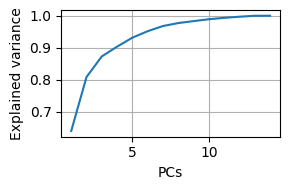

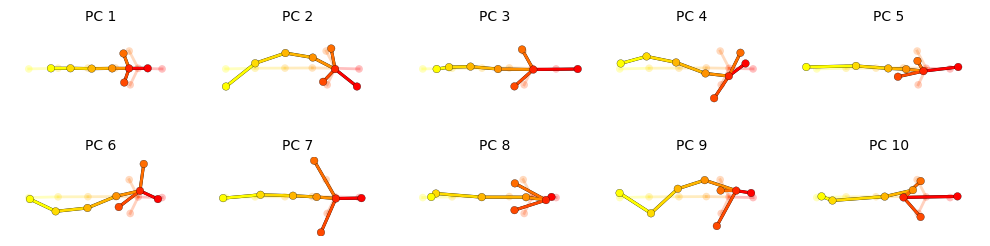

In [9]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# use the following to load an already fit model
# pca = kpms.load_pca(project_dir)

In [23]:
kpms.update_config(project_dir, latent_dim=5)

# Model fitting

Fitting a keypoint-MoSeq model involves:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM:** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling. 
3. **Fitting the full model:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Extracting model results:** The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.
4. **[Optional] Applying the trained model:** The learned model parameters can be used to infer a syllable sequences for additional data.

## Setting kappa

Most users will need to adjust the **kappa** hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.
- The full model will generally require a lower value of kappa to yield the same target syllable durations. 
- To adjust the value of kappa in the model, use `kpms.update_hypparams` as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.

**Kappa scan

Fitting model with kappa=10.0
Outputs will be saved to Chronic_LDOPA\kappa_scan-10.0


 49%|█████████████████▏                 | 25/51 [12:00<12:20, 28.48s/it]

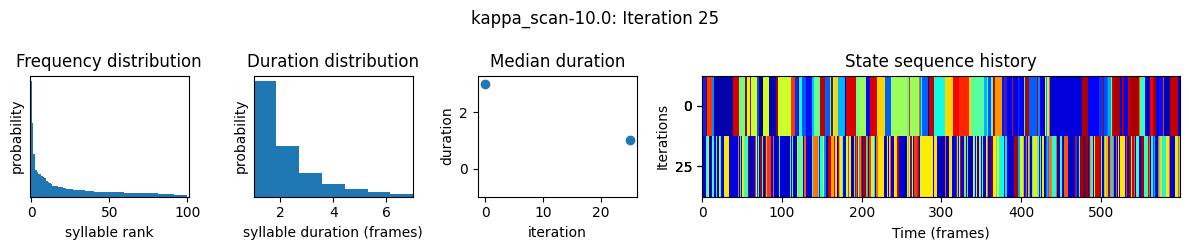

 98%|██████████████████████████████████▎| 50/51 [24:01<00:29, 29.20s/it]

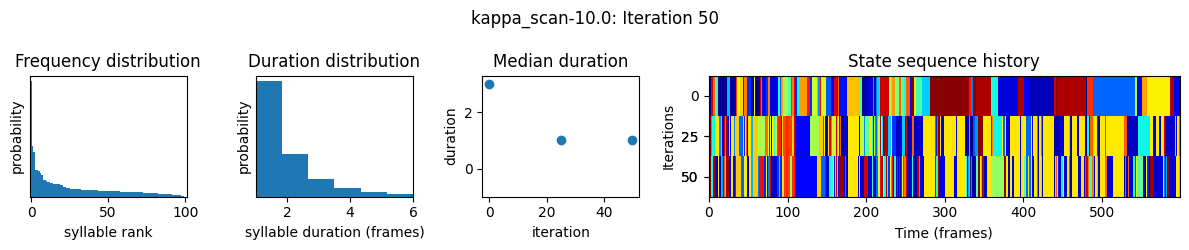

100%|███████████████████████████████████| 51/51 [24:32<00:00, 28.87s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-10.0


 49%|█████████████████▏                 | 25/51 [29:26<30:13, 69.75s/it]

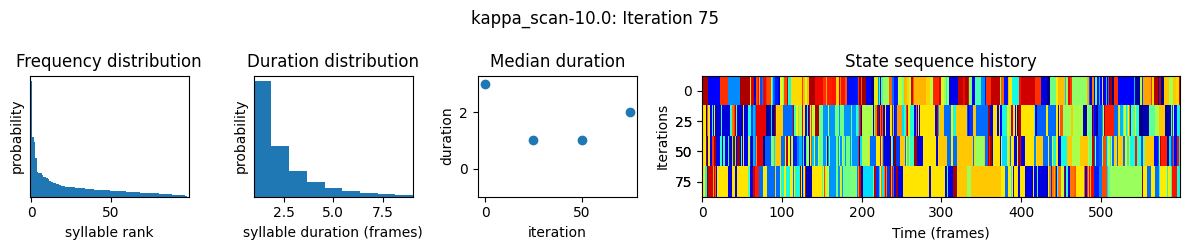

 98%|██████████████████████████████████▎| 50/51 [58:18<01:09, 69.05s/it]

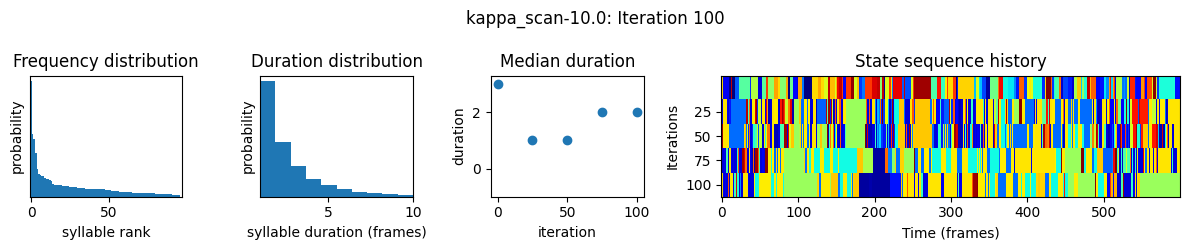

100%|███████████████████████████████████| 51/51 [59:29<00:00, 69.99s/it]


Fitting model with kappa=71.96856730011521
Outputs will be saved to Chronic_LDOPA\kappa_scan-71.96856730011521


 49%|█████████████████▏                 | 25/51 [12:06<12:40, 29.24s/it]

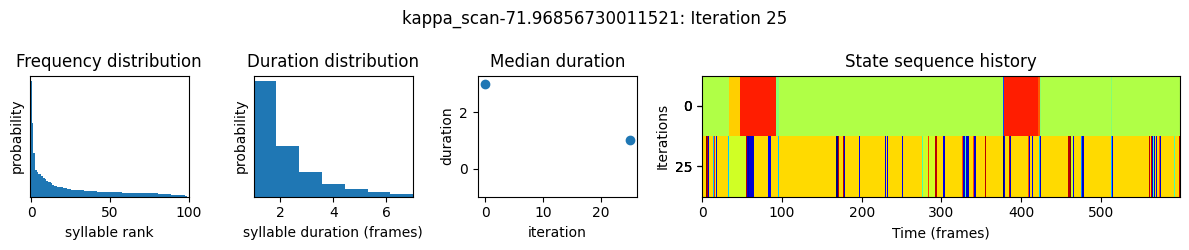

 98%|██████████████████████████████████▎| 50/51 [24:20<00:29, 29.58s/it]

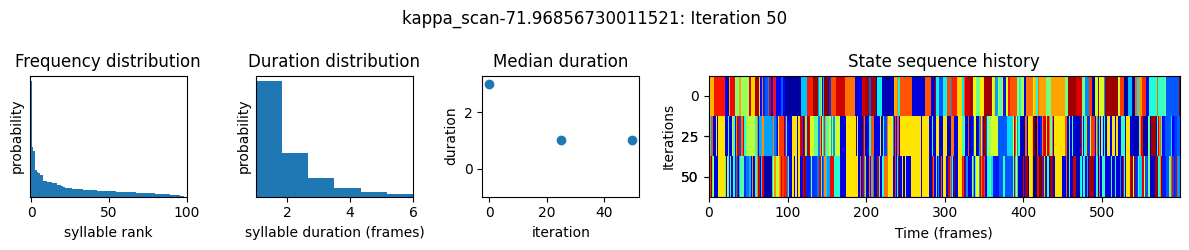

100%|███████████████████████████████████| 51/51 [24:51<00:00, 29.24s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-71.96856730011521


 49%|█████████████████▏                 | 25/51 [29:11<30:17, 69.91s/it]

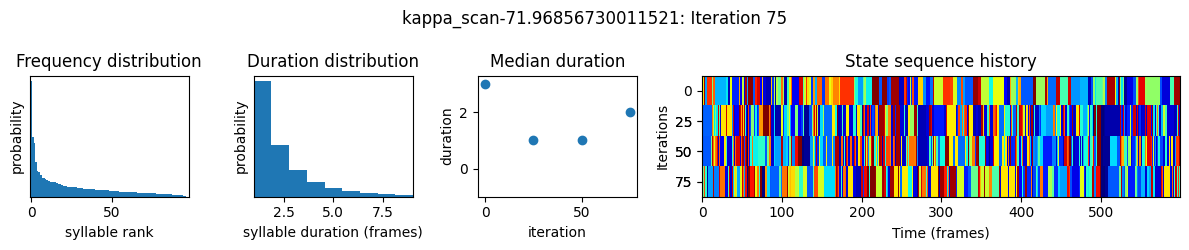

 98%|██████████████████████████████████▎| 50/51 [58:28<01:10, 70.19s/it]

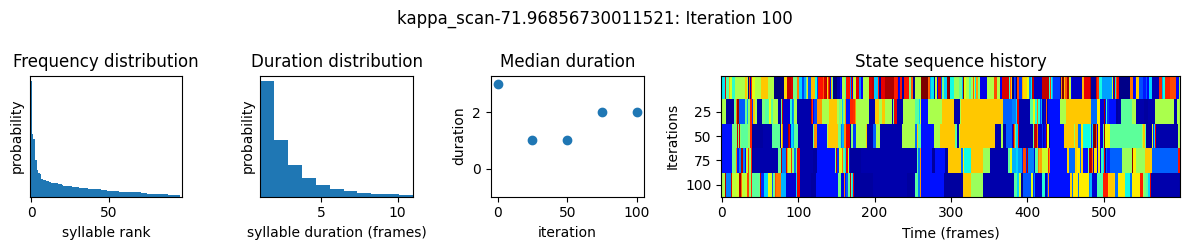

100%|███████████████████████████████████| 51/51 [59:41<00:00, 70.22s/it]


Fitting model with kappa=517.9474679231213
Outputs will be saved to Chronic_LDOPA\kappa_scan-517.9474679231213


 49%|█████████████████▏                 | 25/51 [12:12<12:39, 29.23s/it]

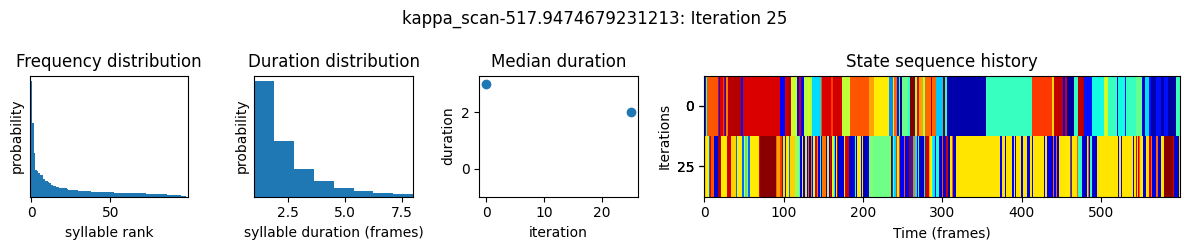

 98%|██████████████████████████████████▎| 50/51 [24:23<00:29, 29.05s/it]

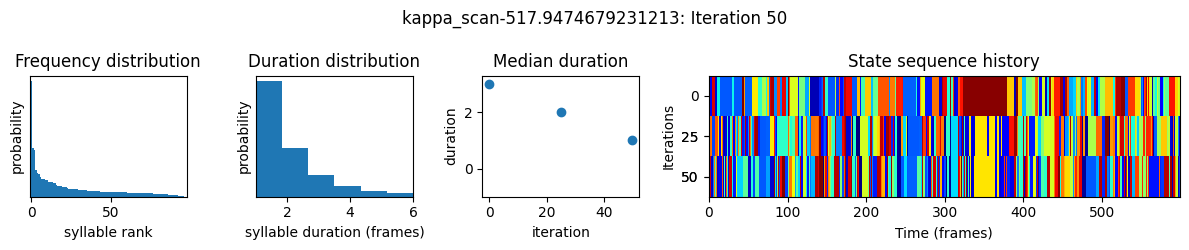

100%|███████████████████████████████████| 51/51 [24:54<00:00, 29.30s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-517.9474679231213


 49%|█████████████████▏                 | 25/51 [29:14<30:39, 70.75s/it]

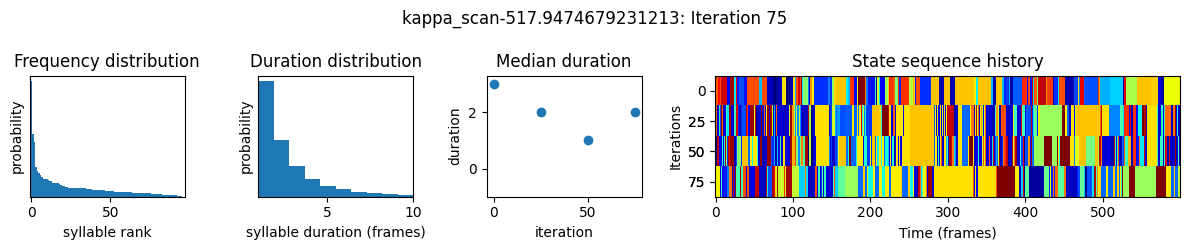

 98%|██████████████████████████████████▎| 50/51 [58:30<01:09, 69.48s/it]

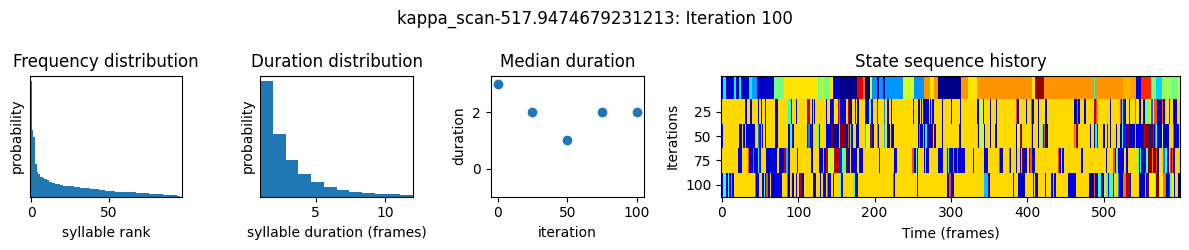

100%|███████████████████████████████████| 51/51 [59:41<00:00, 70.23s/it]


Fitting model with kappa=3727.593720314938
Outputs will be saved to Chronic_LDOPA\kappa_scan-3727.593720314938


 49%|█████████████████▏                 | 25/51 [11:59<12:26, 28.72s/it]

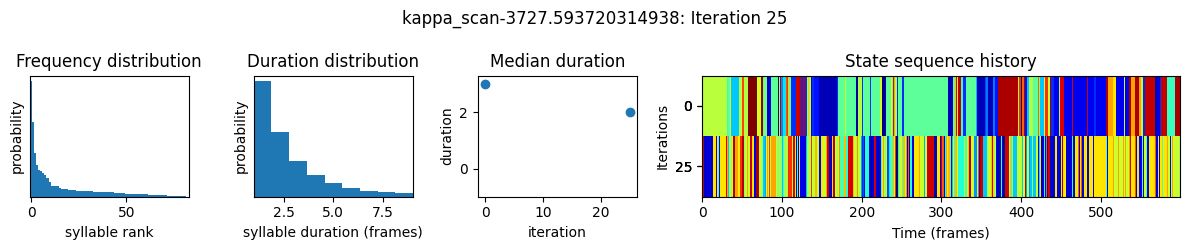

 98%|██████████████████████████████████▎| 50/51 [24:08<00:29, 29.54s/it]

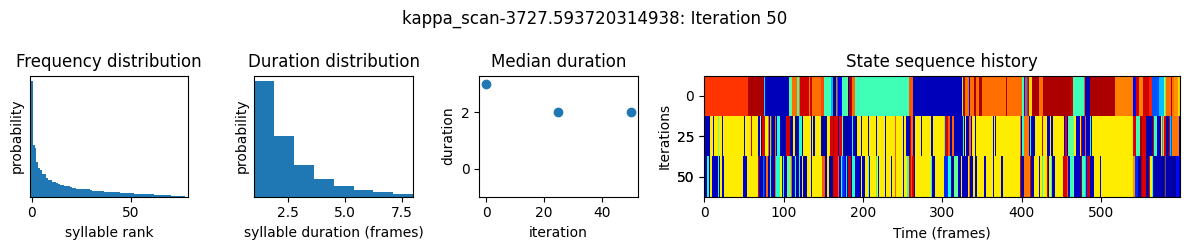

100%|███████████████████████████████████| 51/51 [24:39<00:00, 29.01s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-3727.593720314938


 49%|█████████████████▏                 | 25/51 [29:52<30:35, 70.60s/it]

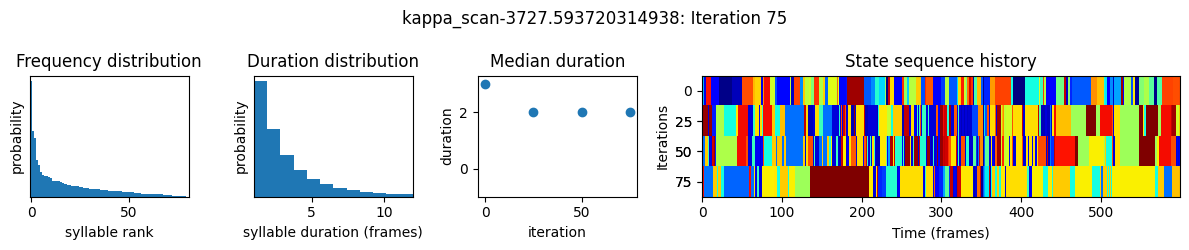

 98%|██████████████████████████████████▎| 50/51 [59:18<01:10, 70.71s/it]

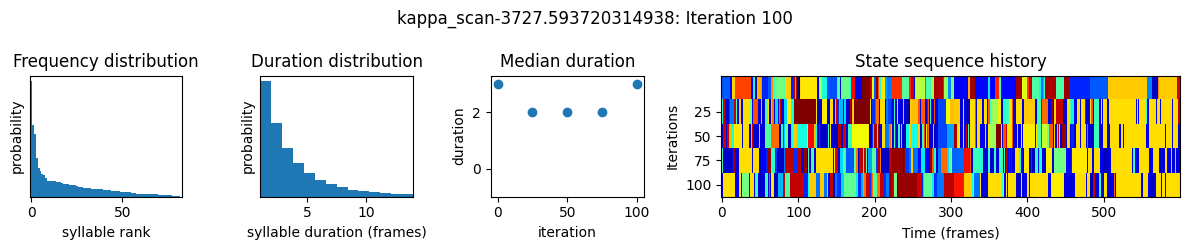

100%|█████████████████████████████████| 51/51 [1:00:32<00:00, 71.22s/it]


Fitting model with kappa=26826.957952797275
Outputs will be saved to Chronic_LDOPA\kappa_scan-26826.957952797275


 49%|█████████████████▏                 | 25/51 [12:11<12:38, 29.17s/it]

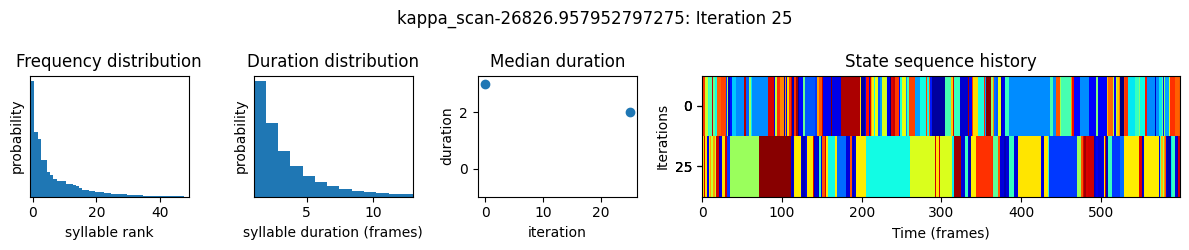

 98%|██████████████████████████████████▎| 50/51 [24:28<00:29, 29.32s/it]

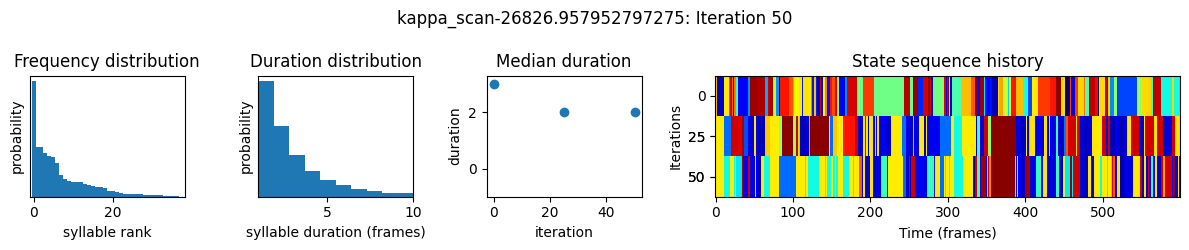

100%|███████████████████████████████████| 51/51 [24:59<00:00, 29.40s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-26826.957952797275


 49%|█████████████████▏                 | 25/51 [29:12<29:55, 69.04s/it]

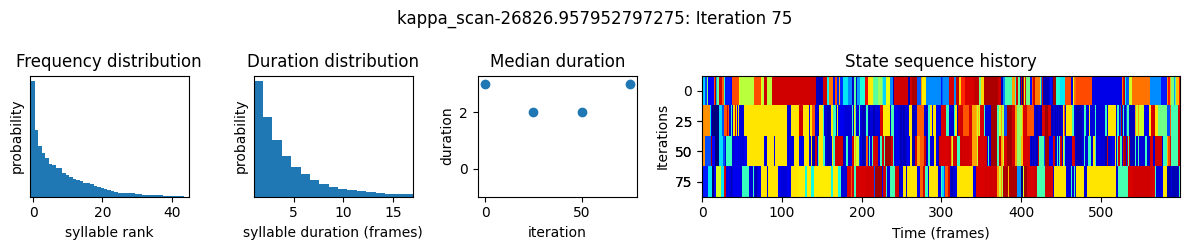

 98%|██████████████████████████████████▎| 50/51 [58:02<01:09, 69.11s/it]

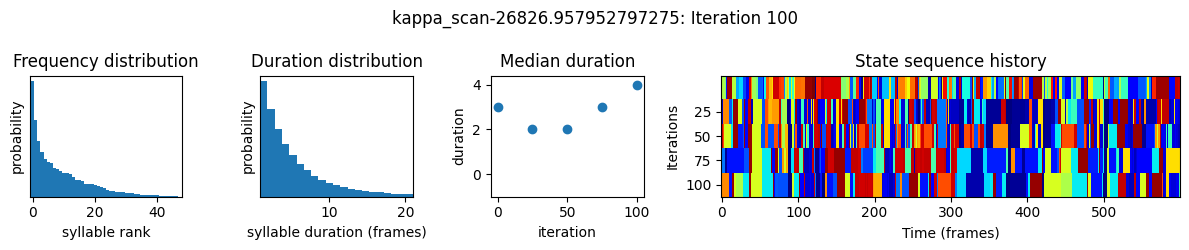

100%|███████████████████████████████████| 51/51 [59:14<00:00, 69.69s/it]


Fitting model with kappa=193069.77288832495
Outputs will be saved to Chronic_LDOPA\kappa_scan-193069.77288832495


 49%|█████████████████▏                 | 25/51 [11:57<12:26, 28.71s/it]

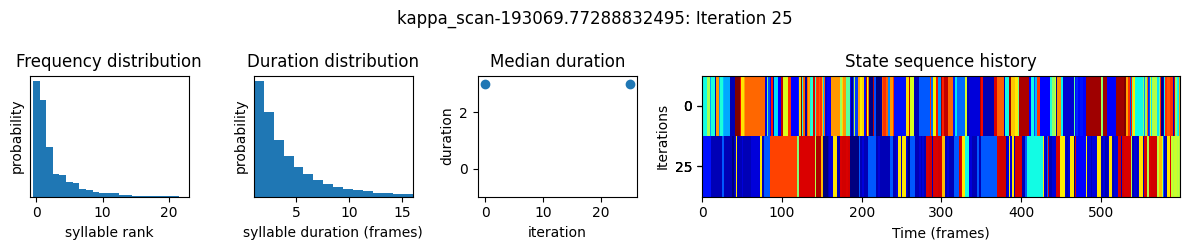

 98%|██████████████████████████████████▎| 50/51 [23:58<00:28, 28.74s/it]

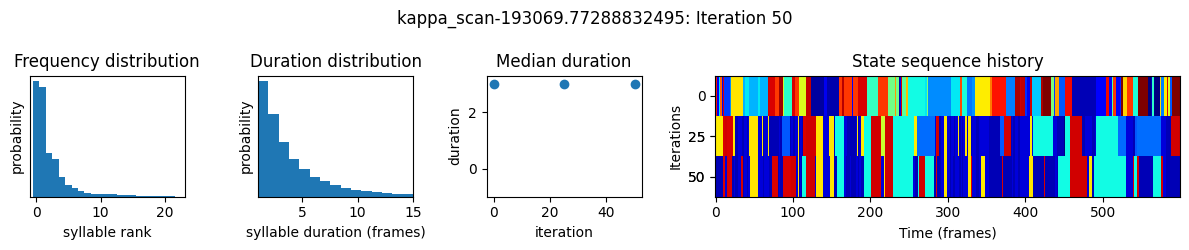

100%|███████████████████████████████████| 51/51 [24:29<00:00, 28.82s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-193069.77288832495


 49%|█████████████████▏                 | 25/51 [28:47<29:56, 69.10s/it]

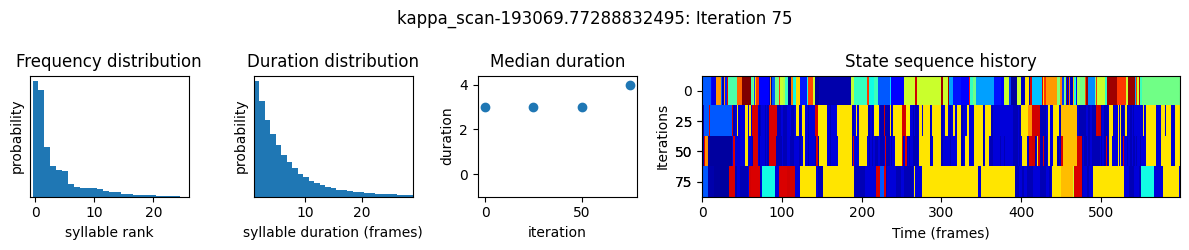

 98%|██████████████████████████████████▎| 50/51 [57:38<01:09, 69.16s/it]

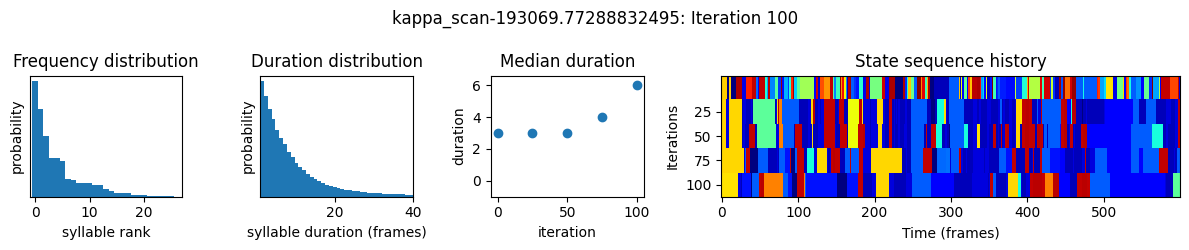

100%|███████████████████████████████████| 51/51 [58:49<00:00, 69.20s/it]


Fitting model with kappa=1389495.494373136
Outputs will be saved to Chronic_LDOPA\kappa_scan-1389495.494373136


 49%|█████████████████▏                 | 25/51 [11:58<12:29, 28.81s/it]

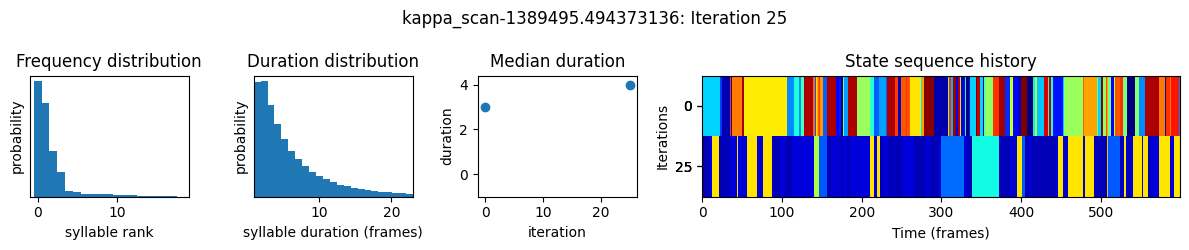

 98%|██████████████████████████████████▎| 50/51 [23:59<00:28, 28.69s/it]

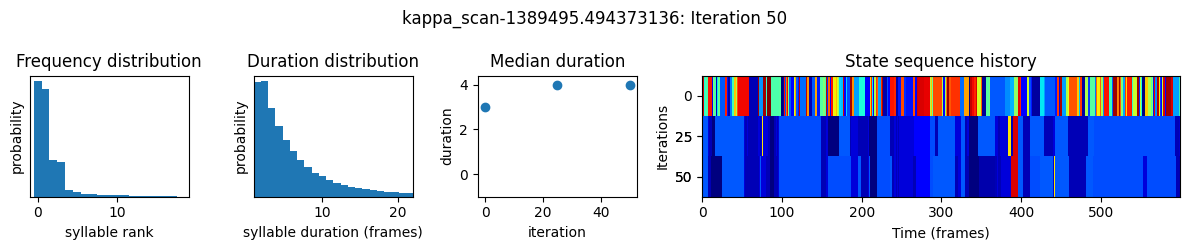

100%|███████████████████████████████████| 51/51 [24:29<00:00, 28.82s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-1389495.494373136


 49%|█████████████████▏                 | 25/51 [28:46<29:52, 68.95s/it]

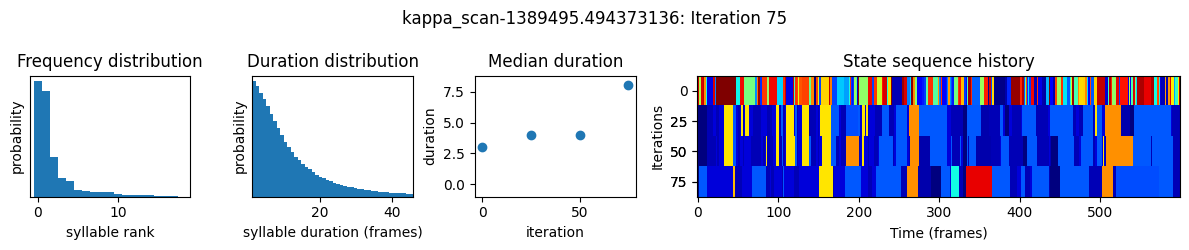

 98%|██████████████████████████████████▎| 50/51 [57:37<01:09, 69.20s/it]

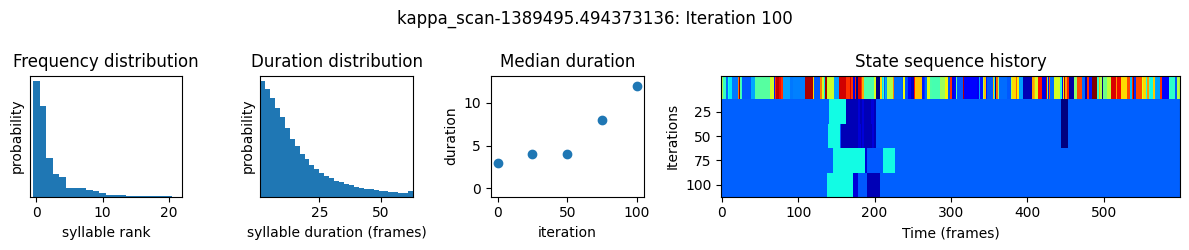

100%|███████████████████████████████████| 51/51 [58:48<00:00, 69.19s/it]


Fitting model with kappa=10000000.0
Outputs will be saved to Chronic_LDOPA\kappa_scan-10000000.0


 49%|█████████████████▏                 | 25/51 [11:57<12:26, 28.71s/it]

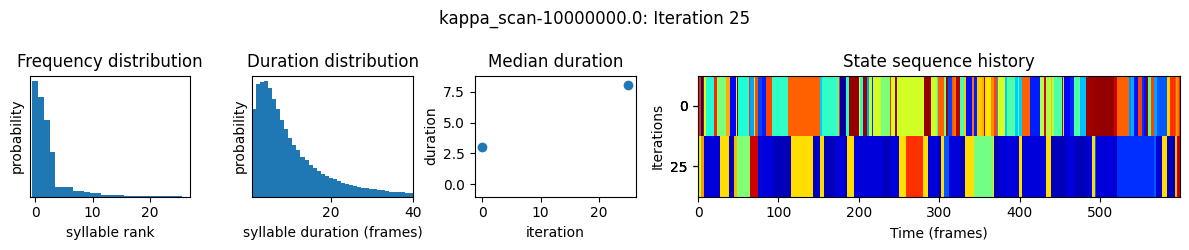

 98%|██████████████████████████████████▎| 50/51 [23:58<00:28, 28.77s/it]

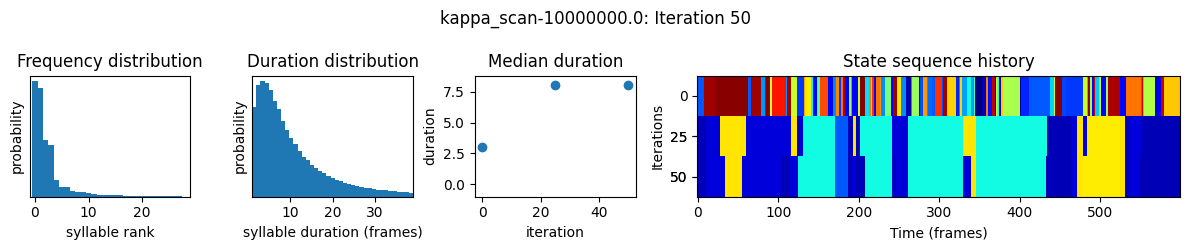

100%|███████████████████████████████████| 51/51 [24:29<00:00, 28.82s/it]


Outputs will be saved to Chronic_LDOPA\kappa_scan-10000000.0


 49%|█████████████████▏                 | 25/51 [28:45<29:52, 68.96s/it]

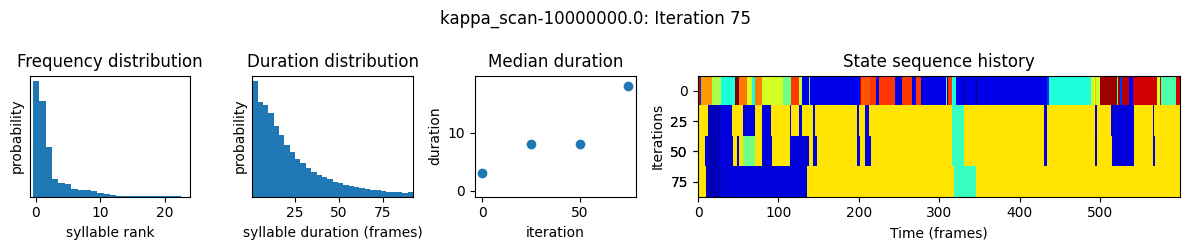

 98%|██████████████████████████████████▎| 50/51 [57:33<01:08, 68.98s/it]

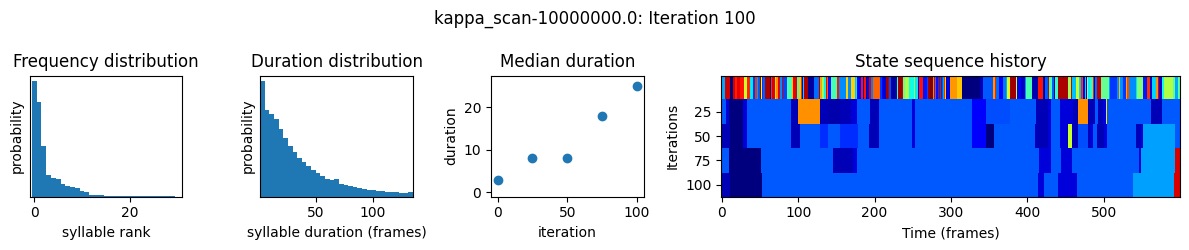

Loading checkpoints: 100%|███████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.70it/s]


(<Figure size 800x250 with 2 Axes>,
 array([ 2.,  2.,  2.,  3.,  4.,  6., 12., 25.]))

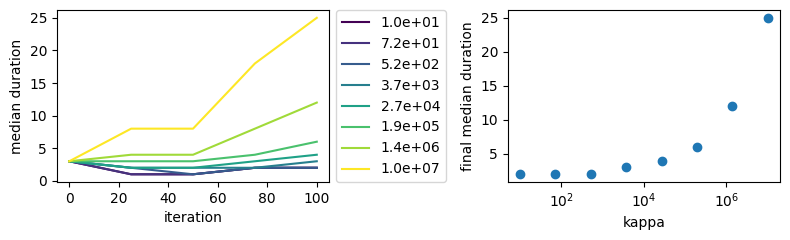

In [14]:
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(4)

import numpy as np

kappas = np.logspace(1,7,8)
decrease_kappa_factor = 10
num_ar_iters = 50
num_full_iters = 100

prefix = 'kappa_scan'

for kappa in kappas:
    print(f"Fitting model with kappa={kappa}")
    model_name = f'{prefix}-{kappa}'
    model = kpms.init_model(data, pca=pca, **config())

    # stage 1: fit the model with AR only
    model = kpms.update_hypparams(model, kappa=kappa)
    model = kpms.fit_model(
        model,
        data,
        metadata,
        project_dir,
        model_name,
        ar_only=True,
        num_iters=num_ar_iters,
        save_every_n_iters=25
    )[0];

    # stage 2: fit the full model
    model = kpms.update_hypparams(model, kappa=kappa/decrease_kappa_factor)
    kpms.fit_model(
        model,
        data,
        metadata,
        project_dir,
        model_name,
        ar_only=False,
        start_iter=num_ar_iters,
        num_iters=num_full_iters,
        save_every_n_iters=25
    );

kpms.plot_kappa_scan(kappas, project_dir, prefix)

In [ ]:
**Fitting multiple models

In [ ]:
import jax

num_model_fits = 20
prefix = 'my_models'

ar_only_kappa = 1e6
num_ar_iters = 50

full_model_kappa = 1e4
num_full_iters = 500

for restart in range(num_model_fits):
    print(f"Fitting model {restart}")
    model_name = f'{prefix}-{restart}'

    model = kpms.init_model(
        data, pca=pca, **config(), seed=jax.random.PRNGKey(restart)
    )

    # stage 1: fit the model with AR only
    model = kpms.update_hypparams(model, kappa=ar_only_kappa)
    model = kpms.fit_model(
        model,
        data,
        metadata,
        project_dir,
        model_name,
        ar_only=True,
        num_iters=num_ar_iters
    )[0]

    # stage 2: fit the full model
    model = kpms.update_hypparams(model, kappa=full_model_kappa)
    kpms.fit_model(
        model,
        data,
        metadata,
        project_dir,
        model_name,
        ar_only=False,
        start_iter=num_ar_iters,
        num_iters=num_full_iters
    );

    kpms.reindex_syllables_in_checkpoint(project_dir, model_name);
    model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)
    results = kpms.extract_results(model, metadata, project_dir, model_name)

In [ ]:
**selecting a model

100%|█████████████████████████████████████| 3/3 [00:46<00:00, 15.65s/it]

Best model: 2024_05_23-17_43_55


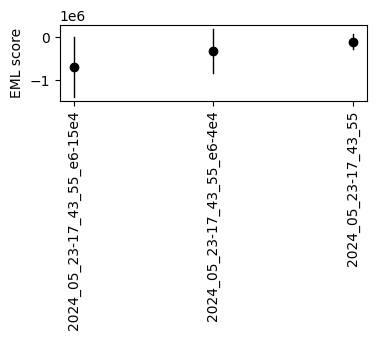

In [41]:
# change the following line as needed
import numpy as np

model_names = ['my_kappa_scan-{}'.format(i) for i in [1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]]

                   

eml_scores, eml_std_errs = kpms.expected_marginal_likelihoods(project_dir, model_names)
best_model = model_names[np.argmax(eml_scores)]

print(f"Best model: {best_model}")

fig1 = kpms.plot_eml_scores(eml_scores, eml_std_errs, model_names)


In [39]:
fig1[1].set_ylim([-600000,600000])

(-600000.0, 600000.0)

['my_kappa_scan-1000.0',
 'my_kappa_scan-10000.0',
 'my_kappa_scan-100000.0',
 'my_kappa_scan-1000000.0',
 'my_kappa_scan-10000000.0',
 'my_kappa_scan-100000000.0',
 'my_kappa_scan-1000000000.0',
 '2024_05_14-16_53_08',
 '2024_05_14-16_53_08 (kappa 1e4)',
 '2024_05_22-13_18_51 (kappa 1e6)',
 '2024_05_22-14_44_01 (kappa 1e5)',
 '2024_05_22-16_02_46 (kappa 1e4)',
 '2024_05_23-11_07_58 (kappa 1e3)']

In [40]:
import matplotlib.pyplot as plt
import os
model_name = 'test'

def save_analysis_figure(fig, plot_name, project_dir, model_name, save_dir):
    """Save an analysis figure.

    The figure is saved as both a .png and .pdf, either to `save_dir` if it is
    provided, or else to `project_dir/model_name/figures`.
    """
    if save_dir is None:
        save_dir = os.path.join(project_dir, model_name, "figures")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, plot_name)
    fig.savefig(save_path + ".png", dpi=300)
    fig.savefig(save_path + ".pdf", dpi=300)
    print(f"Saved figure to {save_path}.png")


#fig1.axes[0].set_ylim(-0.005,.08)
#fig1
save_analysis_figure(fig1[0], 'Model_Scores2', project_dir, model_name, save_dir='MITOPARK_DLC')

Saved figure to MITOPARK_DLC\Model_Scores2.png


## Initialization

In [18]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config())

# optionally modify kappa
model = kpms.update_hypparams(model, kappa=1e4)

## Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below:
- generates a name for the model and a corresponding directory in `project_dir`
- saves a checkpoint every 25 iterations from which fitting can be restarted
- plots the progress of fitting every 25 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - a sample of the syllable sequence across iterations in a random window

Outputs will be saved to Chronic_LDOPA\2024_09_10-12_05_47


 20%|██████▊                            | 10/51 [04:49<19:46, 28.93s/it]

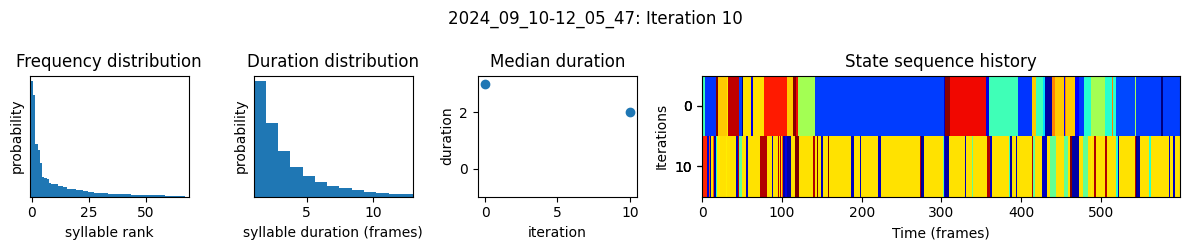

 39%|█████████████▋                     | 20/51 [09:42<15:01, 29.10s/it]

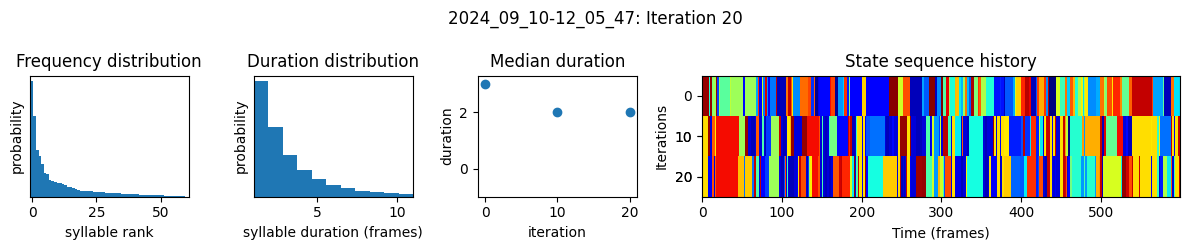

 59%|████████████████████▌              | 30/51 [14:36<10:11, 29.10s/it]

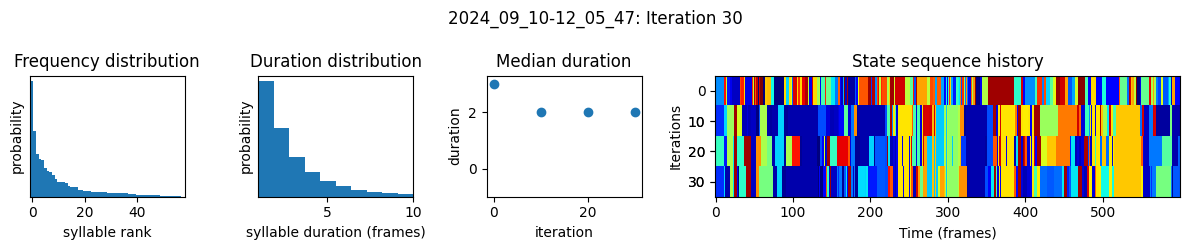

 78%|███████████████████████████▍       | 40/51 [19:29<05:19, 29.05s/it]

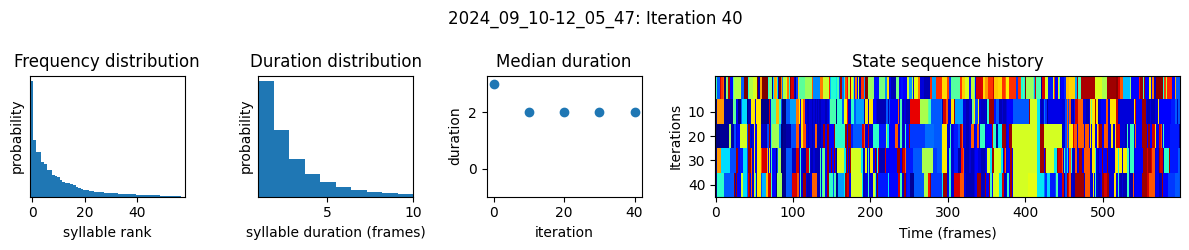

 98%|██████████████████████████████████▎| 50/51 [24:23<00:29, 29.08s/it]

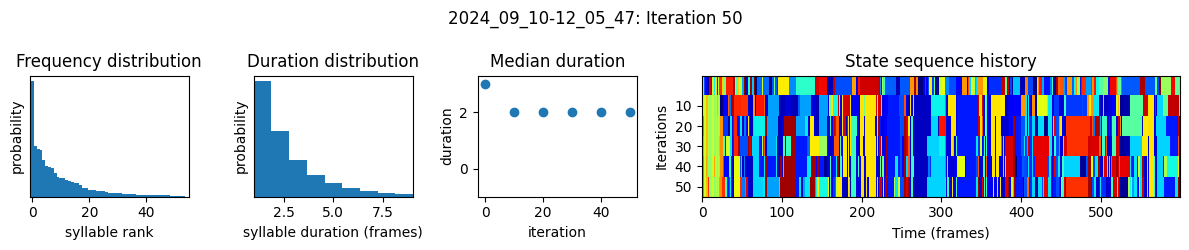

100%|███████████████████████████████████| 51/51 [24:55<00:00, 29.32s/it]


In [19]:
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(8)

num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, save_every_n_iters=10, num_iters=num_ar_iters)

## Fitting the full model

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step. 

C:\Programming\keypoint-moseq\keypoint_moseq\fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to Chronic_LDOPA\2024_09_10-12_05_47


 12%|███▉                            | 25/201 [28:38<3:22:07, 68.91s/it]

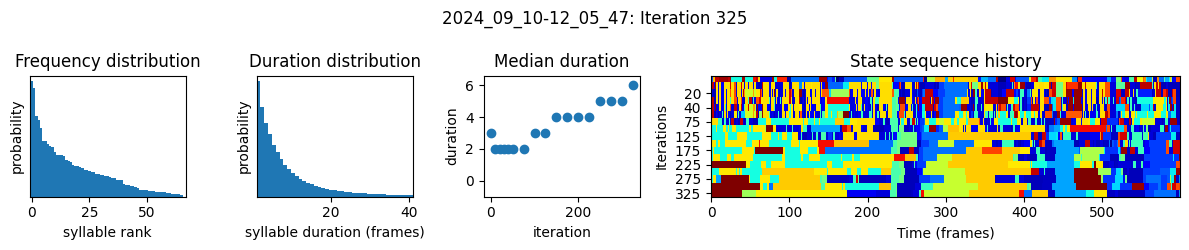

 25%|███████▉                        | 50/201 [57:20<2:52:55, 68.71s/it]

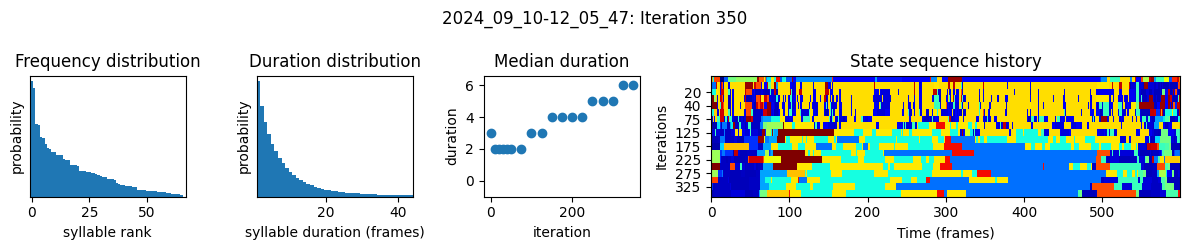

 37%|███████████▏                  | 75/201 [1:26:03<2:24:26, 68.78s/it]

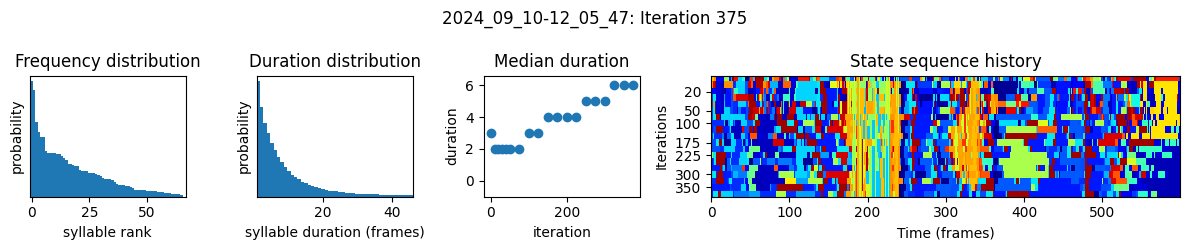

 50%|██████████████▍              | 100/201 [1:54:47<1:55:41, 68.73s/it]

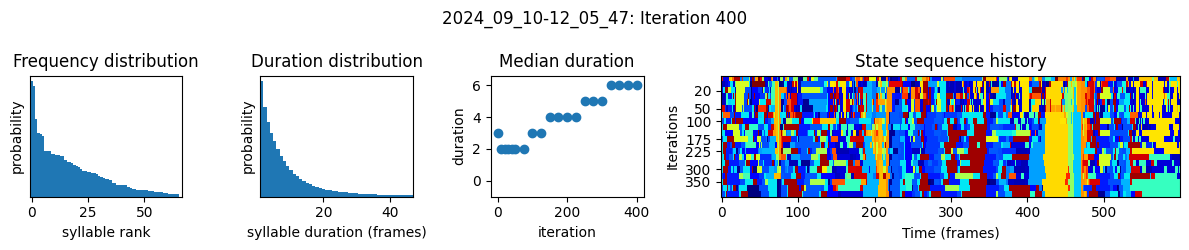

 62%|██████████████████           | 125/201 [2:23:27<1:27:05, 68.75s/it]

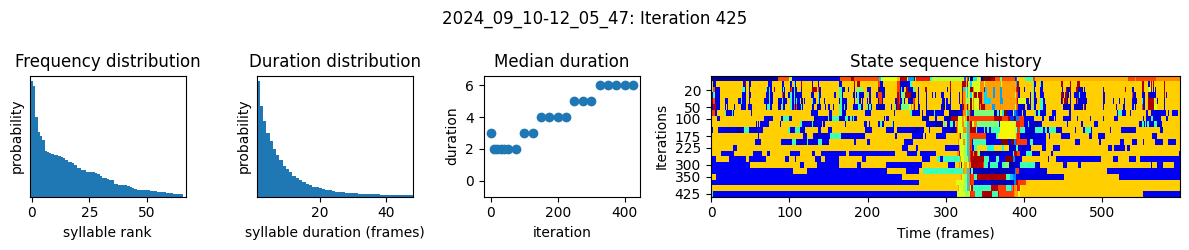

 75%|███████████████████████▏       | 150/201 [2:52:11<58:32, 68.87s/it]

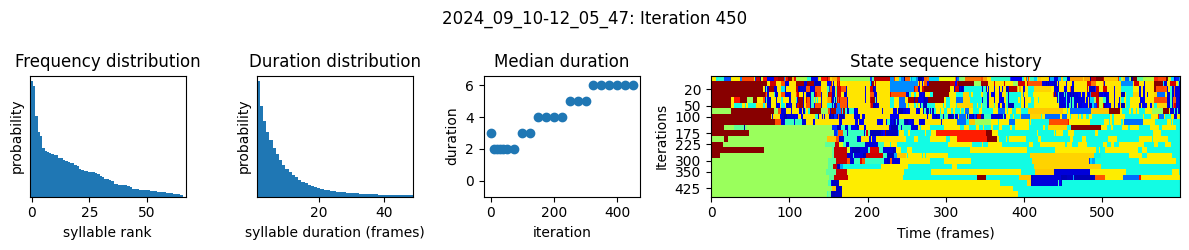

 87%|██████████████████████████▉    | 175/201 [3:21:04<30:17, 69.90s/it]

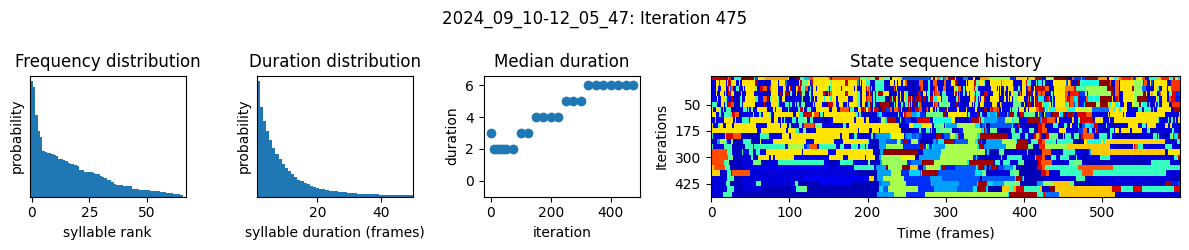

100%|██████████████████████████████▊| 200/201 [3:49:34<01:08, 68.33s/it]

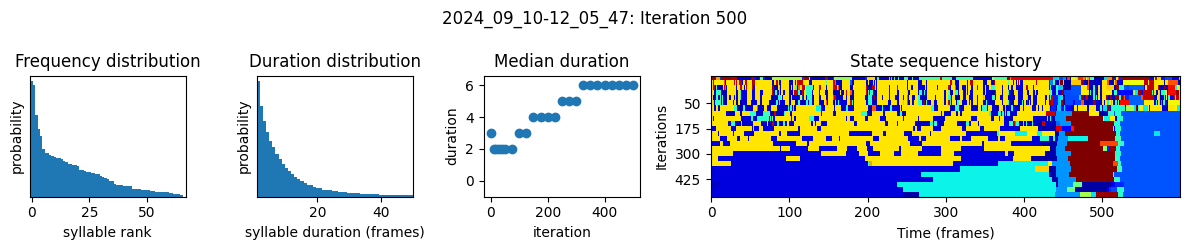

100%|███████████████████████████████| 201/201 [3:50:46<00:00, 68.89s/it]


In [6]:
from jax_moseq.utils import set_mixed_map_iters
set_mixed_map_iters(16)

model_name = '2024_09_10-12_05_47'
num_ar_iters = 300


# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=5000)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False, 
    start_iter=300, num_iters=500)[0]


## Sort syllables by frequency

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that `0` is the most frequent, `1` is the second most, and so on). 

In [36]:
# modify a saved checkpoint so syllables are ordered by frequency
model_name = '2024_09_06-18_30_53'
kpms.reindex_syllables_in_checkpoint(project_dir, model_name);

Reindexing: 100%|███████████| 26/26 [00:48<00:00,  1.85s/model snapshot]


```{warning}
Reindexing is only applied to the checkpoint file. Therefore, if you perform this step after extracting the modeling results or generating vizualizations, then those steps must be repeated.
```

## Extract model results

Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [37]:
# load the most recent model checkpoint
#model_name = '2024_08_30-17_25_39'
#model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

Saved results to Chronic_LDOPA\2024_09_06-18_30_53\results.h5


### [Optional] Save results to csv

After extracting to an h5 file, the results can also be saved as csv files. A separate file will be created for each recording and saved to `{project_dir}/{model_name}/results/`. 

In [38]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Saving to csv: 100%|██████████████████| 250/250 [00:21<00:00, 11.53it/s]


## Apply to new data

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add**.

In [27]:
# load the most recent model checkpoint and pca object
model = kpms.load_checkpoint(project_dir, model_name)[0]

# load new data (e.g. from deeplabcut)
new_data = '6OHDA_DLC/video/' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut', extension='.h5')
data, metadata = kpms.format_data(coordinates, confidences, **config())

# apply saved model to new data
results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
# kpms.save_results_as_csv(results, project_dir, model_name)

Applying model: 100%|███████████████| 500/500 [3:34:16<00:00, 25.71s/it]

Saved results to MITOPARK_DLC\2024_05_23-17_43_55_e6-4e4\results.h5


# Visualization

## Trajectory plots
Generate plots showing the median trajectory of poses associated with each given syllable. 

In [39]:
model_name = '2024_09_06-18_30_53'
results = kpms.load_results(project_dir, model_name)

In [40]:
project_dir = 'Chronic_LDOPA'
model_name = '2024_09_06-18_30_53'
new_data = 'Chronic_LDOPA/tracking/' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut', extension='.csv')
data, metadata = kpms.format_data(coordinates, confidences, **config())


results = kpms.load_results(project_dir, model_name)



Loading keypoints: 100%|██████████████| 250/250 [00:14<00:00, 17.76it/s]


Saving trajectory plots to Chronic_LDOPA\2024_09_06-18_30_53\trajectory_plots


Generating trajectory plots: 100%|██████| 45/45 [00:21<00:00,  2.11it/s]


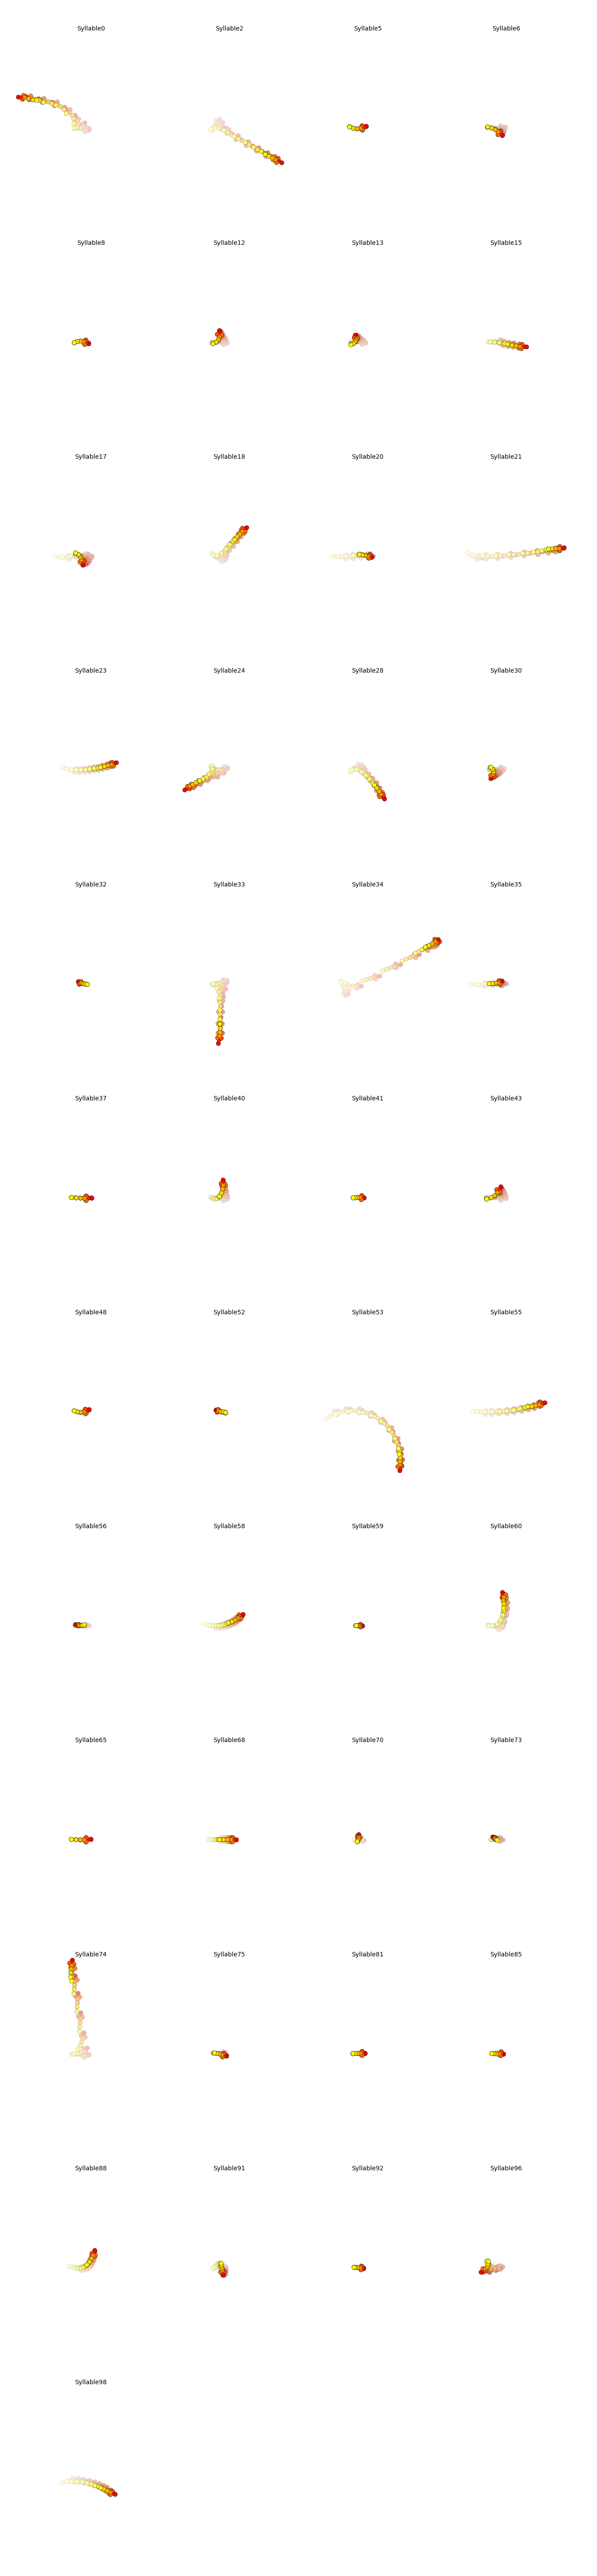

In [41]:
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

## Grid movies
Generate video clips showing examples of each syllable. 

*Note: the code below will only work with 2D data. For 3D data, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#making-grid-movies-for-3d-data).*

In [42]:
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates,  **config());

Writing grid movies to Chronic_LDOPA\2024_09_06-18_30_53\grid_movies
Using window size of 176 pixels


Generating grid movies: 100%|███████████| 45/45 [01:08<00:00,  1.52s/it]


## Syllable Dendrogram
Plot a dendrogram representing distances between each syllable's median trajectory.

Saving dendrogram plot to Chronic_LDOPA\2024_09_06-18_30_53\similarity_dendrogram


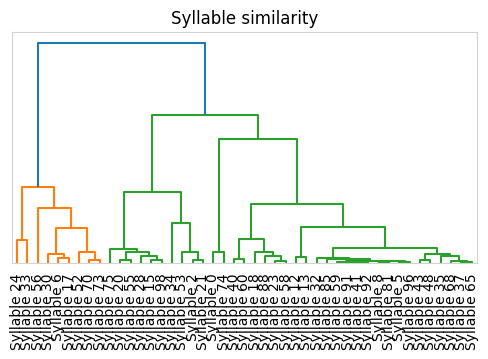

In [43]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())